In [1]:
using LinearAlgebra
using SparseArrays
using Plots

In [2]:
using Revise
using LatticeQM

┌ Info: Precompiling LatticeQM [606d2a7e-9b17-11e9-1c5c-455b84f60309]
└ @ Base loading.jl:1313


In [3]:
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# Calculation

In [4]:
lat = Geometries2D.honeycomb()
sx, sy, sz, sublA, sublB = getoperator(lat, ["SX", "SY", "SZ", "sublatticeAspin", "sublatticeBspin"])

hops = Operators.graphene(lat; mode=:spinhalf)
# Operators.addzeeman!(hops, lat, r->sign(r[4]-0.5).*0.5.*[sin(0.0π),0,cos(0.0π)] )

ks = kpath(lat; num_points=200)

nothing

Computing bands... 100%|████████████████████████████████| Time: 0:00:03


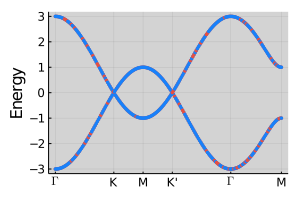

In [5]:
ks = kpath(lat; num_points=200)
bands = getbands(hops, ks, sz)
p1 = plot(bands; markersize=2, size=(300,200))

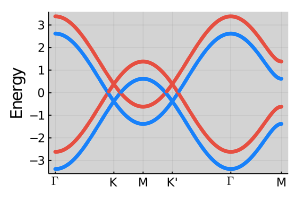

In [10]:
hopsBDG = BdGOperator(hops)
Operators.setfilling!(hopsBDG, 0.48)

eOP = Superconductivity.electron(hopsBDG)

ks = kpath(lat; num_points=200)
bands = getbands(hopsBDG.h, ks, eOP.h)
p1 = plot(bands; markersize=2, size=(300,200))

In [ ]:
# ##Meanfield.getcappedyukawa(lat; format=:dense, mode=:nospin, k0=0.5, U=2.3)

# v = gethubbard(lat; mode=:σx, a=0.5, U=5.0) # interaction potential
# ρ_init = initialguess(v, :random; lat=lat) # initial guess
# hf = hartreefock(hops, v)

# ρ_sol, ϵ_GS, HMF, converged, error = Meanfield.solveselfconsistent( # run the calculation
#     hf, ρ_init, 0.75; klin=30, iterations=800, tol=1e-7,# p_norm=Inf,
#     T=0.01, β=0.25,  show_trace=true, clear_trace=true
# )

# nothing

In [27]:
hopsBDG = BdGOperator(hops)
# v = gethubbard(lat; mode=:σx, a=0.5, U=-2.0) # interaction potential
v = Meanfield.getshortrangedpotential(lat, -2.2, 0.1)

ρ0_init = initialguess(v, :random; kind=:nonlocal) # initial guess
Δ0_init = initialguess(v, :random; kind=:nonlocal) # initial guess
ρ_init = BdGOperator(ρ0_init, Δ0_init)

ρ_sol, ϵ_GS, HMF, converged, error = Meanfield.solvehartreefock( # run the calculation
    hopsBDG, v, ρ_init, 0.48; klin=10, iterations=800, tol=1e-5,# p_norm=Inf,
    T=0.01, β=0.3,  show_trace=true, clear_trace=true
)
Operators.addchemicalpotential!(HMF.h, -HMF.μ)

nothing

FIXPOINT SEARCH  Time: 0:00:08 (695 iterations)
  iter:  695


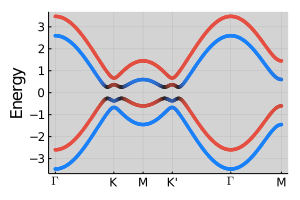

In [28]:
hmf = HMF.h
eOP = Superconductivity.electron(hmf)

bands_mf = getbands(hmf.h, ks, eOP.h)
# bands_mf.bands .-= HMF.μ # shift chemical potential to zero
p2 = plot(bands_mf; markersize=2, size=(300,200))

In [68]:
BANDGAP = Spectrum.bandgap(DenseHops(hmf.h); klin=30)

0.3271009919026462

In [69]:
Δ0_sol = Superconductivity.getpairingsector(ρ_sol) * (1im*getoperator(lat, "sy"))
NONSWAVE = round.(Operators.localmagnetization(Δ0_sol, lat); digits=8)
SWAVE = abs.(Operators.localdensity(Δ0_sol,lat))
# Δnambu = round.(Δ0_sol[[0,0]]; digits=3)

SWAVE[1]-SWAVE[2]

-1.065036645153672e-6

In [48]:
ρ0_sol = TightBinding.getelectronsector(ρ_sol)
M = real.(Operators.localmagnetization(ρ0_sol, lat))
δM = M[:,1] - M[:,2]; M = M[:,1] + M[:,2]
Mabs = norm(M); δMabs = norm(δM)
dens = Operators.localdensity(ρ0_sol,lat)
# @info("Groundstate energy", ϵ_GS)
# @info("Magnetization", Mabs, δMabs, M, δM)
# @info("Density", dens)

2-element Vector{ComplexF64}:
 0.9002966465787691 - 7.2178184874500584e-65im
 0.9007117220851855 + 8.34898081084869e-65im

In [ ]:
bands_mf = getbands(HMF.h, ks, sz)
bands_mf.bands .-= HMF.μ # shift chemical potential to zero
p2 = plot(bands_mf; markersize=2, size=(300,200))